In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.formula.api as smf

%matplotlib inline

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [5]:
from VQR import VectorQuantileRegression

In [6]:
X = pd.read_excel('Data/MVEngel.xls', 'X' ,header= None)
Y = pd.read_excel('Data/MVEngel.xls', 'Y' ,header= None).fillna(0)

X.columns = ['income']

Y.columns = ['food',
'clothing',
'housing',
'heating/lightening',
'tools',
'education',
'public safety',
'health',
'services'
]

Y_col = Y.columns

data = pd.concat([X,Y], axis =1)

In [7]:
X.head()

,income
0,835.94
1,873.44
2,951.44
3,473.00
4,601.00


In [8]:
Y.head()

,food,clothing,housing,heating/lightening,tools,education,public safety,health,services
0,576.28,129.34,78.32,46.80,0.0,0.0,0.0,5.2,0.0
1,631.80,83.00,79.80,73.84,0.0,5.0,0.0,0.0,0.0
2,608.64,134.00,108.00,78.00,0.0,5.0,0.0,17.8,0.0
3,301.00,40.00,76.00,46.00,0.0,0.0,2.0,8.0,0.0
4,378.00,65.00,84.00,50.00,0.0,0.0,6.0,18.0,0.0


In [9]:
q = [0.10, 0.25, 0.5,0.75, 0.9]
qtl = []
for i in q:
    qtl += list(np.quantile(X, i, axis=0))
qtl

[504.5040000000001, 638.875, 883.99, 1163.9850000000001, 1539.0]

# 1D plot

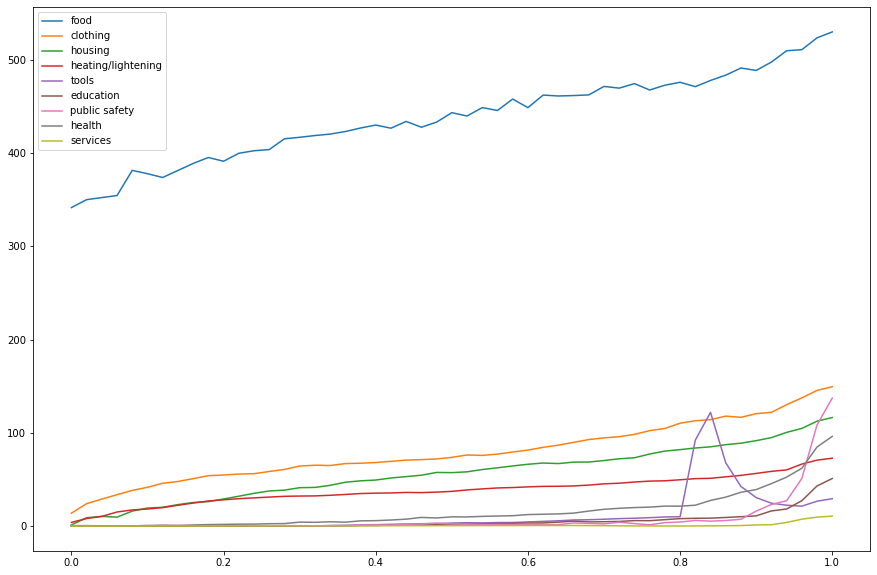

In [10]:
k = 1


for col in Y_col:
    vqr = VectorQuantileRegression()
    vqr.fit(X,Y[[col]], step=0.02)
    vqr.plot_surface(pd.DataFrame([qtl[k]]), legend = col)
    plt.legend()

## vs Classique Quantile Regression

C:\Users\delan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\delan\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


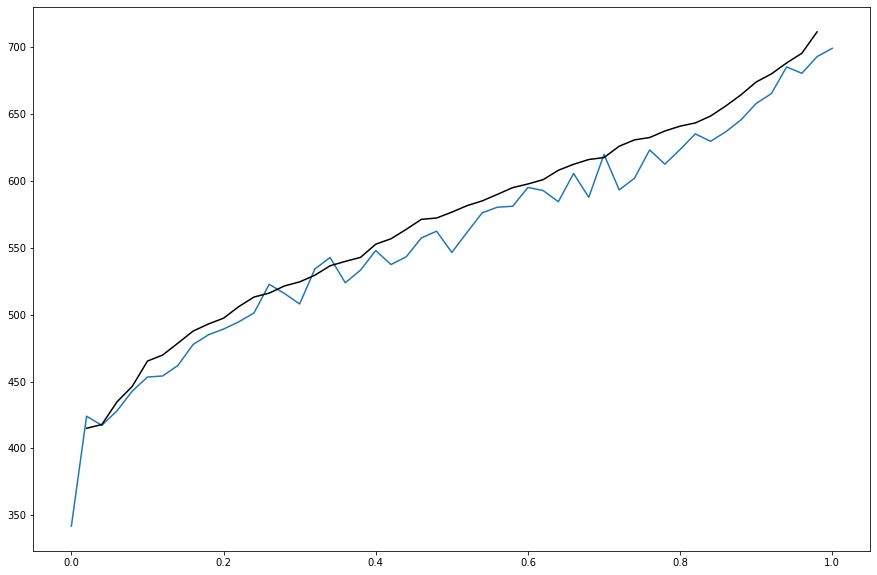

In [11]:
data = Y.copy()
data['income'] = X
step = 0.02

for col in [Y_col[0]]:
    x_test = 883.99
    vqr = VectorQuantileRegression()
    vqr.fit(X,Y[[col]], step=step)
    df = vqr.predict(pd.DataFrame([x_test]))
    plt.plot(df[0].ravel(), df['y_pred'].apply(lambda x: np.abs(x)[0][0]).ewm(span=3).mean())
    
    mod = smf.quantreg(col+' ~ income', data)
    quantiles = np.arange(0+step, 1, step)
    def fit_model(q):
        res = mod.fit(q=q)
        return [q, res.params['Intercept'], res.params['income']] + \
                res.conf_int().loc['income'].tolist()

    models = [fit_model(x) for x in quantiles]
    models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])

    n = models.shape[0]
    p1 = plt.plot(models.q, models.a + models.b*x_test, color='black', label='Quantile Reg.')

## Food 1d

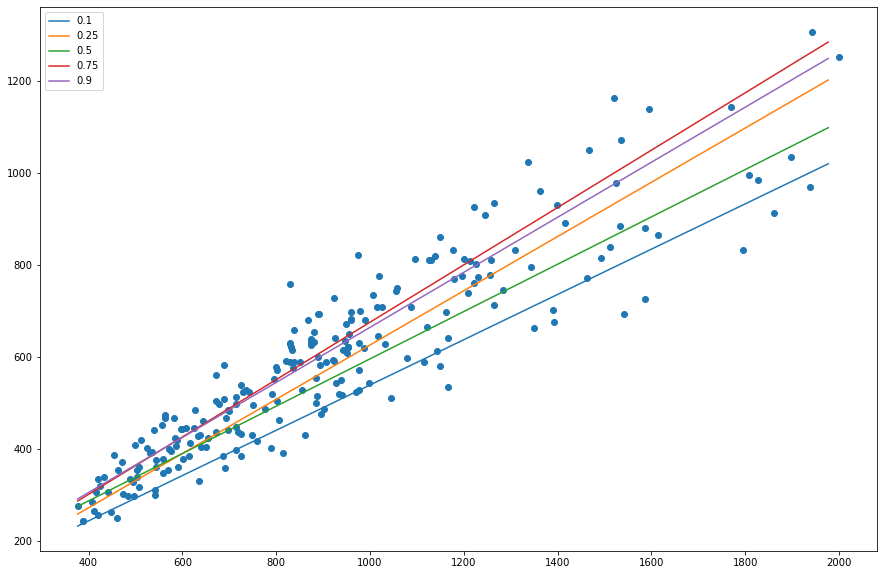

In [12]:
x = data[data['income'] <2000][['income']]
y =data[data['income'] <2000][['food']]

vqr = VectorQuantileRegression()
vqr.fit(x,y, step=0.01)

x_test = np.arange(int(np.min(X)), 2000, 100)
x_test = pd.DataFrame(x_test)

l_res = []
l_q = [0.10,0.25, 0.5,0.75, 0.9]
for i in l_q:
    res = vqr.predict(x_test, u_quantile=[i], argument="X")['y_pred'].apply(lambda x : x[0][0]).ravel()
    l_res += [res]

plt.scatter(x['income'].ravel(), y['food'].ravel())
for p in range(len(l_res)):
    plt.plot(x_test[0].ravel(),l_res[p], label=l_q[p])
plt.legend()

## Housing 1d

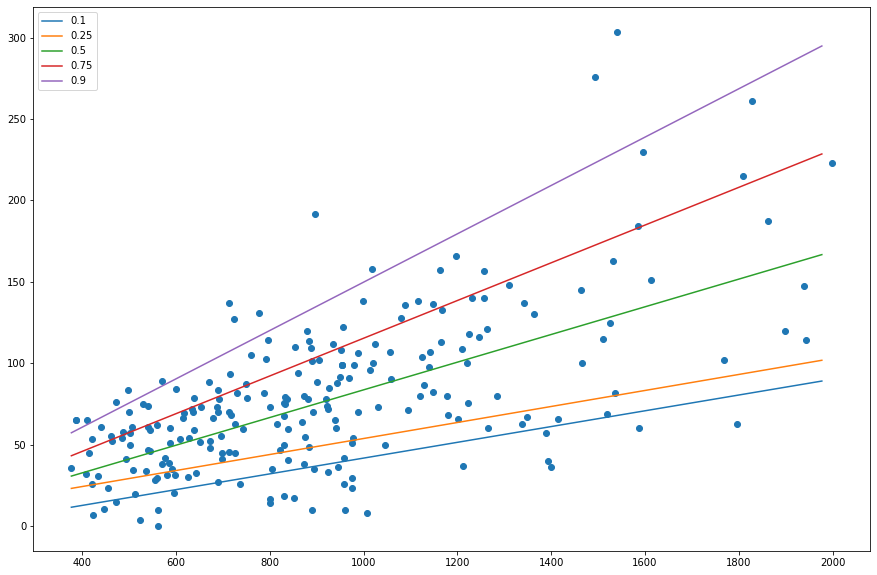

In [13]:
x = data[data['income'] <2000][['income']]
y =data[data['income'] <2000][['housing']]

vqr = VectorQuantileRegression()
vqr.fit(x,y, step=0.01)

x_test = np.arange(int(np.min(X)), 2000, 100)
x_test = pd.DataFrame(x_test)

l_res = []
l_q = [0.10,0.25, 0.5,0.75, 0.9]
for i in l_q:
    res = vqr.predict(x_test, u_quantile=[i], argument="X")['y_pred'].apply(lambda x : x[0][0]).ravel()
    l_res += [res]

plt.scatter(x['income'].ravel(), y['housing'].ravel())
for p in range(len(l_res)):
    plt.plot(x_test[0].ravel(),l_res[p], label=l_q[p])
plt.legend()

# 2d Plot

## Surface

In [14]:
from mpl_toolkits.mplot3d import Axes3D

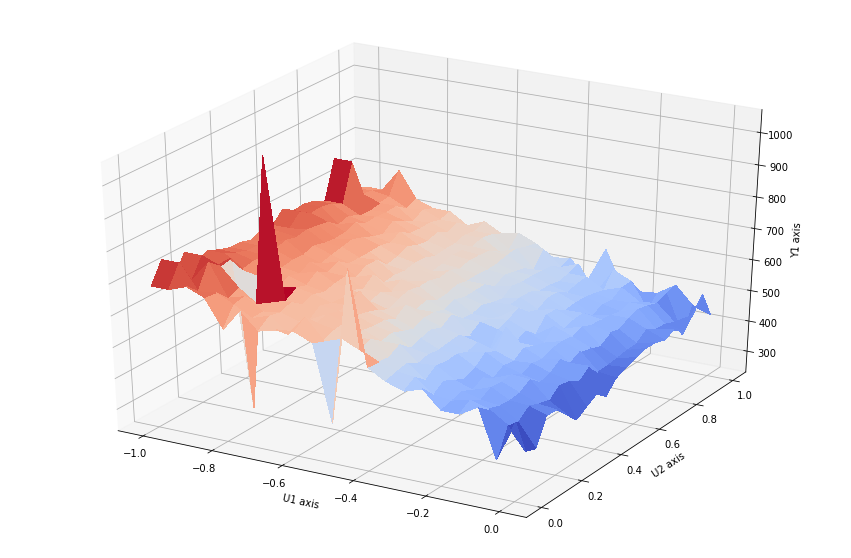

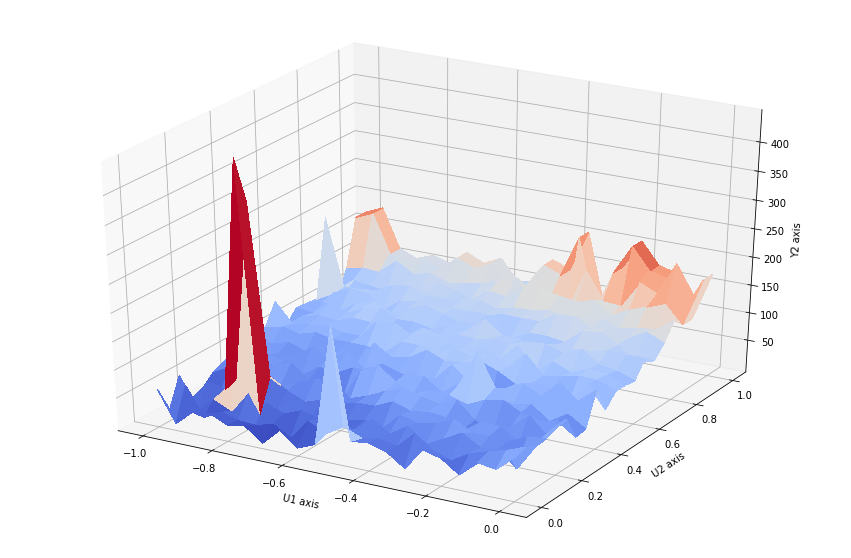

In [15]:
vqr = VectorQuantileRegression()
vqr.fit(X,Y[Y_col[[0,2]]], step=0.05)
vqr.plot_surface(pd.DataFrame([883.99]))

## Consumption % evolution

In [16]:
x = data[data['income'] <2000][['income']]
y =data[data['income'] <2000][['food','clothing']]

vqr = VectorQuantileRegression()
vqr.fit(x,y, step=0.05)

x_test = np.concatenate([np.arange(400, 1000, 100), np.arange(1000, 2200, 400)])
x_test = pd.DataFrame(x_test)

l_res0 = []
l_res1 = []
l_q = [0.10, 0.5,0.9]
l_q2 = []
for i in l_q:
    for k in l_q:
        res0 = vqr.predict(x_test, u_quantile=[i, k], argument="X")['y_pred'].apply(lambda x : x[0][0]).ravel()
        l_res0 += [res0]
        res1 = vqr.predict(x_test, u_quantile=[i, k], argument="X")['y_pred'].apply(lambda x : x[1][0]).ravel()
        l_res1 += [res1]
        l_q2 += [[i, k]]
    
   

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

Text(0, 0.5, '% clothing expense in total income')

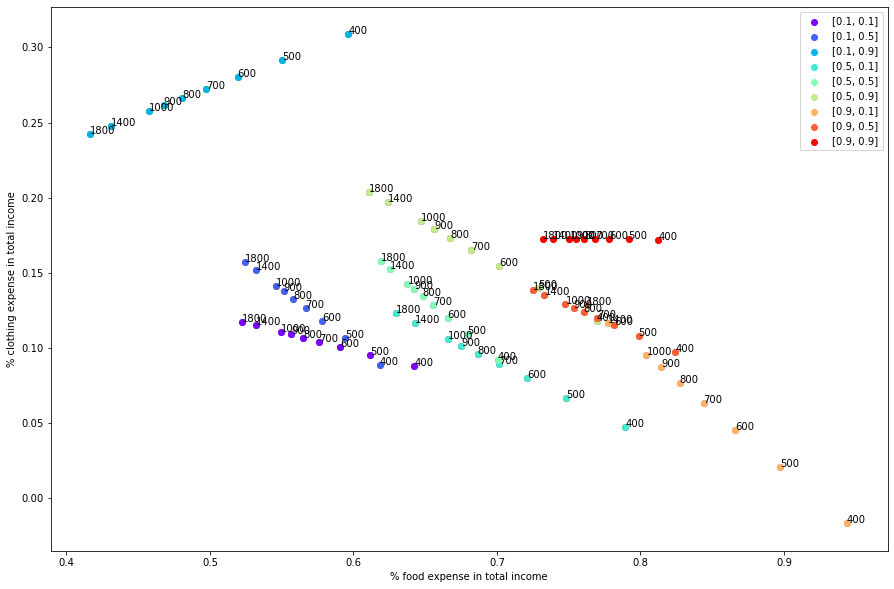

In [17]:
n = x_test[0].ravel()

fig, ax = plt.subplots()

colors = cm.rainbow(np.linspace(0, 1, len(l_q2)))
for j in range(len(l_q2)):
    z = l_res0[j]/n
    y = l_res1[j]/n
    plt.scatter(z, y)
    ax.scatter(z, y, label=l_q2[j], c = colors[j])
    for i, txt in enumerate(n):
        ax.annotate(txt, (z[i], y[i]))
    plt.legend()
    
ax.set_xlabel('% food expense in total income')
ax.set_ylabel('% clothing expense in total income')


https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html